# Diagnosing Covid-19 from Radiology Images using AI Model

## Import python libraries

*   Install necessary python libraries to the Google Colab environment
*   Import requisite packages



In [ ]:
!pip install tensorflow==2.18.1 ml_dtypes==0.5 -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.6/615.6 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 84.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 113.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-text 2.19.0 requires tensorflow<2.20,>=2.19.0, but you have tensorflow 2.18.1 which is incompatible.
tf-keras 2.19.0 requires tensorflow<2.20,>=2.19, but you have tensorflow 2.18.1 which is incompatible.
tensorflow-decision-forests 1.12.0 requires tensorflow==2.19.0, but you have tensorflow 2.18.1 which is incompatible.


In [ ]:
import numpy as np
import tensorflow as tf    # Building a Neural Network
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator   # Data augmentation by generating new images
from tensorflow.keras.models import Sequential   # Type of Neural Network
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D,BatchNormalization
from keras.applications.vgg16 import VGG16    # Importing trained feature extraction layers
from sklearn.metrics import recall_score, confusion_matrix  # Evaluate performance of Neural Network

# random state for reproducibility
random_state = 42
import random as python_random
np.random.seed(random_state)
python_random.seed(random_state)
tf.random.set_seed(random_state)

## Load the radiology images

*   Unpack the dataset from the zip file



In [ ]:
# extract the radiology data
!unzip "/content/Data1.zip"

Archive:  /content/Data1.zip
   creating: Data1/
  inflating: Data1/.DS_Store         
   creating: Data1/test/
   creating: Data1/test/Covid/
  inflating: Data1/test/Covid/0100 - Copy.jpeg  
  inflating: Data1/test/Covid/0100.jpeg  
  inflating: Data1/test/Covid/0102 - Copy.jpeg  
  inflating: Data1/test/Covid/0102.jpeg  
  inflating: Data1/test/Covid/0105 - Copy.png  
  inflating: Data1/test/Covid/0105.png  
  inflating: Data1/test/Covid/0106 - Copy.jpeg  
  inflating: Data1/test/Covid/0106.jpeg  
  inflating: Data1/test/Covid/0108 - Copy.jpeg  
  inflating: Data1/test/Covid/0108.jpeg  
  inflating: Data1/test/Covid/0111 - Copy.jpg  
  inflating: Data1/test/Covid/0111.jpg  
  inflating: Data1/test/Covid/0112 - Copy.jpg  
  inflating: Data1/test/Covid/0112.jpg  
  inflating: Data1/test/Covid/0113 - Copy.jpg  
  inflating: Data1/test/Covid/0113.jpg  
  inflating: Data1/test/Covid/0115 - Copy.jpeg  
  inflating: Data1/test/Covid/0115.jpeg  
  inflating: Data1/test/Covid/0118 - Copy.jpeg

Using ImageDataGenerator:
*   We will load the data from the unzipped folder
*   Also identify the classes (i.e. Normal, Covid or Pneumonia) for the training data based on the folder the image was found in
*   We need the training data images with the known classes so that we can train our Neural network



In [ ]:
# all images are fixed size
height, width = 224, 224
# Load 64 images in one go
batch_size=64

TRAINING_DIR = '/content/Data1/train'
TESTING_DIR = '/content/Data1/test'

def generate_data(DIR):
    # ImageDataGenerator is a function from tensorflow to perform rescaling, resizing, rotation, and other transformations.
    datagen = ImageDataGenerator(rescale=1./255.)

    # flow from directory is used to generate batches of image data from a directory structure, allowing for efficient loading and preprocessing of image data during model training or evaluation.
    generator = datagen.flow_from_directory(
        DIR,
        batch_size=batch_size,
        shuffle=True,                                                          # shuffles the order of images while generation
        seed=random_state,
        class_mode='sparse',
        target_size=(height, width),
        classes={'Normal': 0, 'Viral Pneumonia': 1,'Covid': 2}
    )
    return generator


train_data = generate_data(TRAINING_DIR)                                       # generate data for training
test_data = generate_data(TESTING_DIR)                                         # generate data for testing

total_image = np.concatenate([train_data.labels,test_data.labels])             # used to access the labels associated with the images

Found 413 images belonging to 3 classes.
Found 112 images belonging to 3 classes.


## Understanding the data

Let's understand our data by:
*   Finding out the number of images we have for each class of data
*   Displaying some of the images to visually see the characteristics of each type of image
*   Further we also want to see if the images are of consistent shape, size and quality. If not, we will have to resize the images because Neural Networks can work on a fixed size of images only.



/tmp/ipython-input-112098432.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis')


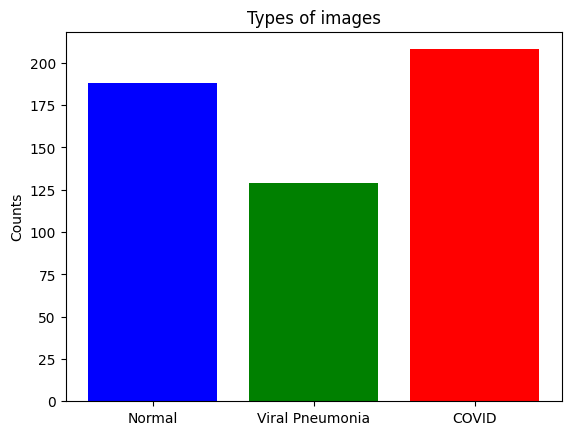

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm



counts = {
    'Normal': len(np.where(total_image == 0)[0]),                              # Calculating the count of Normal images
    'Viral Pneumonia': len(np.where(total_image == 1)[0]),                     # Calculating the count of Viral Pneumonia images
    'COVID': len(np.where(total_image == 2)[0])                                # Calculating the count of COVID images
}

# Extract class labels and corresponding counts
class_labels = list(counts.keys())
class_counts = list(counts.values())

# Normalize the data to range [0, 1]
norm = plt.Normalize(min(class_counts), max(class_counts))
# Get a colormap
cmap = cm.get_cmap('viridis')
# Generate colors for each bar
colors = cmap(norm(class_counts))

# Create the bar plot
plt.bar(class_labels, class_counts, color=['blue', 'green', 'red'])
plt.ylabel('Counts')
plt.title('Types of images');

So here we have:
*   Around 180 radiology images or X-ray scans of Normal People
*   Around 125 x-ray images of people with Pneumonia
*   Around 210 x-ray images of people with Covid


Next we are going to Plot the images to visually understand them



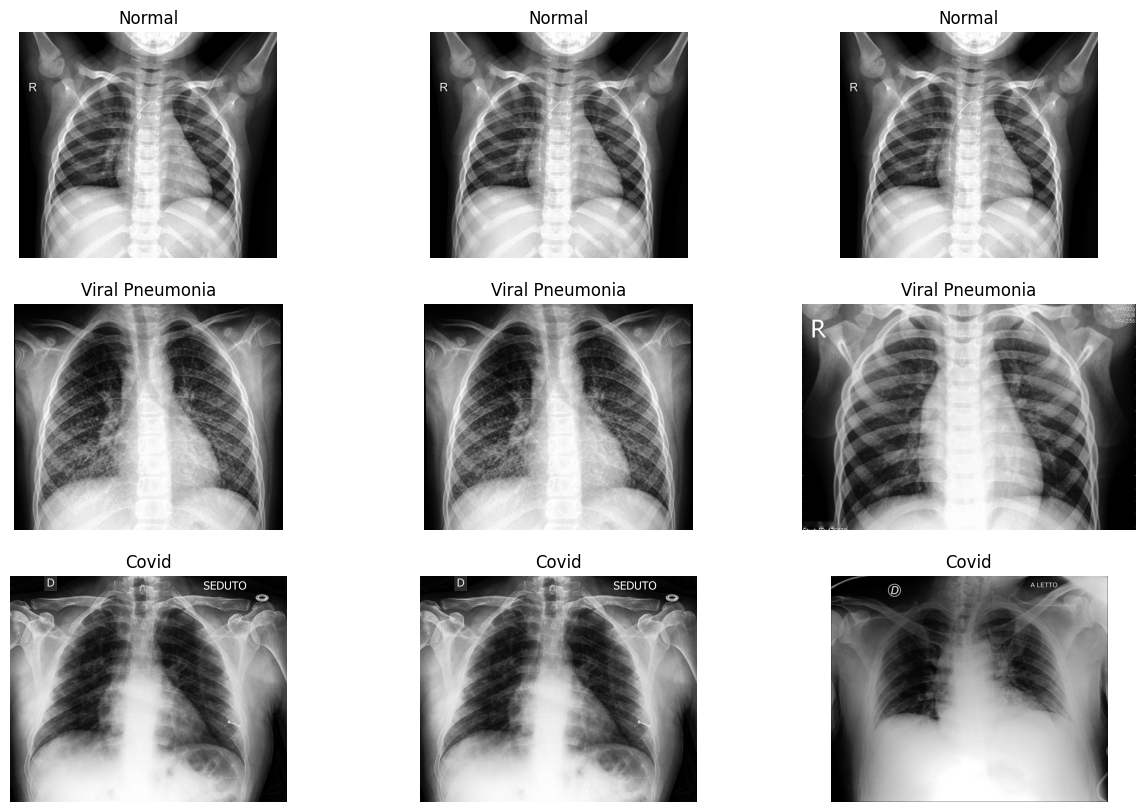

In [ ]:
def image_plot(generator, images_per_class):
    # Get the mapping of class names to indices
    class_indices = generator.class_indices
    # Extract the class names from the indices
    class_names = list(class_indices.keys())

    # Create a figure to display the images
    plt.figure(figsize=(15, 10))

    # Loop through each class index and its corresponding class name
    for class_idx, class_name in enumerate(class_names):
        # Get the indices of images belonging to the current class
        class_indices = [i for i, value in enumerate(generator.classes) if value == class_idx]
        # Select a subset of indices for the current class based on 'images_per_class'
        selected_indices = class_indices[:images_per_class]

        # Loop through the selected indices and display the images
        for i, idx in enumerate(selected_indices):
            # Create a subplot for each image
            ax = plt.subplot(len(class_names), images_per_class, class_idx * images_per_class + i + 1)
            # Load and display the image
            img = plt.imread(generator.filepaths[idx])
            plt.imshow(img)
            plt.title(class_name)
            plt.axis("off")

# Assuming 'train_data' is your image generator
images_per_class = 3
image_plot(train_data, images_per_class)
plt.show()

# Model building

Since our training data is very small, this is not enough to train Neural network. We need lots of images with a lot of diversity - such as images rotated, flipped, shifted horizontally or vertically - so that our model can train for different qualities of x-ray images coming from multiple sources

To do this we use python's **ImageDataGenerator**.

### Data Augmentation

In [ ]:
# adding image augmentation
def generate_data_augmented(DIR):
    datagen = ImageDataGenerator(                                              # Image data generator is a function from tensorflow to perform rescaling, resizing, rotation, and other transformations.
        rescale=1./255.,                                                       # Rescale pixel values to [0, 1]
        zoom_range=0.2,                                                        # Randomly zooms images by a factor of 0.1
        rotation_range=25,                                                     # Randomly rotates images by up to 20 degrees
        width_shift_range=0.15,                                                # Randomly shifts images horizontally by 10% of the total width
        height_shift_range=0.15,                                               # Randomly shifts images vertically by 10% of the total height
        horizontal_flip = True                                                 # Randomly flips images horizontally
    )
    generator = datagen.flow_from_directory(
        TRAINING_DIR,                                                          # Directory containing the training images
        batch_size=batch_size,                                                 # Batch size for generating augmented data
        seed=42,                                                               # Seed value for random number generation
        class_mode='binary',                                                   # Type of class assignment ('binary' in this case)
        target_size=(height, width),                                           # Desired size (height, width) for the images
        classes={'Normal': 0, 'Viral Pneumonia': 1,'Covid': 2}                 # Mapping of class names to numerical labels
    )
    return generator

aug_train_data = generate_data_augmented(TRAINING_DIR)

Found 3728 images belonging to 3 classes.


### Creating the AI model (Neural Network)

Next we are going to define our Neural Network. This is our AI model which will use:
*   Standard VGG16 model for extracting features or patterns out of x-ray images
*   A fully connected Neural Network for learning how the patterns in the images correlate to diagnosis of Normal, Pneumonia or Covid
*   The Neural network, along with VGG16 model:
      * Consume x-ray images
      * Produce 3 output values for each image showing the **probabilities predicted by our AI model that the input x-ray image is for a Normal patient, Pneumonia patient, or patient with Covid**.



In [ ]:
# defining the model architecture
tf.keras.backend.clear_session()                                               # Clears the Keras session to remove any existing models or layers

input_shape = (height, width, 3)                                               # Defines the input shape for the model (height, width, number of channels)
base_model = tf.keras.applications.vgg16.VGG16(
    weights='imagenet',                                                        # Loads the pre-trained weights of the VGG16 model trained on ImageNet dataset
    include_top=False,                                                         # Excludes the top (fully connected) layers of the VGG16 model
    input_shape=input_shape
)
base_model.trainable = False                                                   # Freezes the weights of the VGG16 model to prevent further training

tuned_ai_model = tf.keras.Sequential()                                            # Creates a sequential model
tuned_ai_model.add(base_model)                                                    # Adds the VGG16 base model to the sequential model
tuned_ai_model.add(tf.keras.layers.GlobalAveragePooling2D())                      # Adds a global average pooling layer

tuned_ai_model.add(tf.keras.layers.Flatten())                                     # Flattens the input for the subsequent fully connected
tuned_ai_model.add(tf.keras.layers.Dense(256, activation='relu'))                 # Adds a fully connected layer with 256 units and ReLU activation
tuned_ai_model.add(tf.keras.layers.Dropout(0.2))                                  # Applies dropout regularization to prevent overfitting
tuned_ai_model.add(tf.keras.layers.Dense(256, activation='relu'))
tuned_ai_model.add(tf.keras.layers.Dropout(0.2))

tuned_ai_model.add(tf.keras.layers.Dense(3, activation='softmax'))                # Adds the final fully connected layer with 3 units and softmax activation

tuned_ai_model.compile(loss='SparseCategoricalCrossentropy',                      # Specifies the loss function for trainin
              optimizer=tf.keras.optimizers.Adam(0.001),                       # Sets the optimizer (Adam) and learning rate
              metrics=['acc'])                                                 # Specifies the metrics to evaluate the model's performance
tuned_ai_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,912,579 (56.89 MB)

 Trainable params: 197,891 (773.01 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

## Train the Neural Network

After defining the Neural network structure, now it is time to train the model. Note that:
*   We will only use the training data for training the Neural network.
*   We will use the test data later for performing tests on the model with the images that it has not seen during training

In [ ]:
import random
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

# defines file path to save the best model weights, define accuracy metric, verbose display updates of the model and saves best model
checkpoint = tf.keras.callbacks.ModelCheckpoint('model/tuned_ai_model_best-qudata.model.keras', monitor='acc', verbose=1, mode='max',save_best_only=True)
# stops the model training if there is no improvement in metrics
early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min",restore_best_weights=True, patience=10)

callbacks_list = [checkpoint,early]

# training the model
history = tuned_ai_model.fit(                                                     # fit the model on training data
        aug_train_data,
        validation_data = test_data,
        epochs=50,                                                             # no of epochs to train the model
        shuffle=False,
        verbose=True,                                                          # Prints updates during training.
        callbacks=callbacks_list
)

Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - acc: 0.4799 - loss: 1.0296
Epoch 1: acc improved from -inf to 0.54265, saving model to model/tuned_ai_model_best-qudata.model.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 100s 3s/step - acc: 0.4815 - loss: 1.0278 - val_acc: 0.6278 - val_loss: 0.8071
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - acc: 0.6297 - loss: 0.8328
Epoch 2: acc improved from 0.54265 to 0.63224, saving model to model/tuned_ai_model_best-qudata.model.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - acc: 0.6298 - loss: 0.8326 - val_acc: 0.6587 - val_loss: 0.7531
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - acc: 0.6493 - loss: 0.8044
Epoch 3: acc improved from 0.63224 to 0.66389, saving model to model/tuned_ai_model_best-qudata.model.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - acc: 0.6497 - loss: 0.8037 - val_acc: 0.7058 - val_loss: 0.7303
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - acc: 0.7043 - loss: 0.7249
Epoch 4: acc improved from 0.66389 to 0.70118, savi

## Model Evaluation

### Model performance on training data

Next we will test the performance or accuracy of our model on the training data. **This is expected to be higher accuracy because this is the data that our model has trained upon!**

In [ ]:
import math
ytrain = np.array([])                                                          # Initialize an empty array for storing true labels of test data
xtrain = []                                                                    # Initialize an empty list for storing test data

for i in range(math.ceil(len(aug_train_data.classes)/batch_size)):             # Loop over test generator batches to extract test data and true labels
    xtrain.append(aug_train_data[i][0])                                        # Append test data to xtest list
    ytrain= np.concatenate((ytrain,aug_train_data[i][-1]))                     # Concatenate true labels to ytest array

xtrain = np.concatenate((xtrain),axis=0)                                       # Concatenate test data along the batch axis

ypred_prob_train_tune = tuned_ai_model.predict(xtrain)                                        # Predict probabilities for the test data
ypred_train_tune = np.argmax(ypred_prob_train_tune,axis=1)                                           # Predicted labels by selecting the class with the highest probability

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 159ms/step


In [ ]:
model_train_score = recall_score(ytrain, ypred_train_tune,average='macro')
print("Model Score on Train Data:", np.round(100*model_train_score, 2))

Model Score on Train Data: 95.56


*   **We get an accuracy of 95% in diagnosing each image from the training data!**
*   This is very good performance



[Text(45.72222222222221, 0.5, 'True label')]

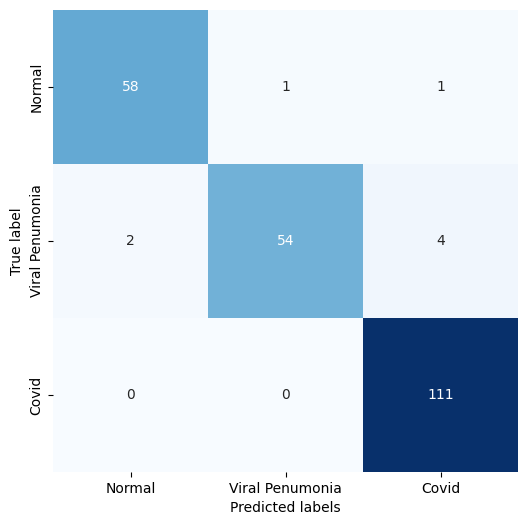

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the size of the figure for the heatmap
plt.figure(figsize=(6, 6))
# Compute the confusion matrix based on true and predicted labels
hm = sns.heatmap(confusion_matrix(ytrain,ypred_train_tune), annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False,xticklabels=['Normal','Viral Penumonia','Covid'],yticklabels=['Normal','Viral Penumonia','Covid'])
hm.set(xlabel='Predicted labels') # Set the x-axis label for the heatmap
hm.set(ylabel='True label') # # Set the y-axis label for the heatmap

### Model performance on test data

Here we will test the performance or accuracy of our model on the test data. **This is expected to be a little lower in accuracy because this is the data that our model has not seen before**

In [ ]:
ytest = np.array([])                                                           # Initialize an empty array for storing true labels of test data
xtest = []                                                                     # Initialize an empty list for storing test data

for i in range(math.ceil(len(test_data.classes)/batch_size)):                  # Loop over test generator batches to extract test data and true labels
    xtest.append(test_data[i][0])                                              # Append test data to xtest list
    ytest= np.concatenate((ytest,test_data[i][-1]))                            # Concatenate true labels to ytest array

xtest = np.concatenate((xtest),axis=0)                                         # Concatenate test data along the batch axis

ypred_prob_test_tune =tuned_ai_model.predict(xtest)                                    # Predict probabilities for the test data
ypred_test_tune = np.argmax(ypred_prob_test_tune,axis=1)                                           # Predicted labels by selecting the class with the highest probability

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step 


In [ ]:
model_test_score = recall_score(ytest, ypred_test_tune,average='macro')
print("Model Score on Test Data:", np.round(100*model_test_score, 2))

Model Score on Test Data: 90.0


*   **We get an accuracy of 91% in diagnosing each image from the test data!**
*   This is also very good performance

[Text(45.72222222222221, 0.5, 'True label')]

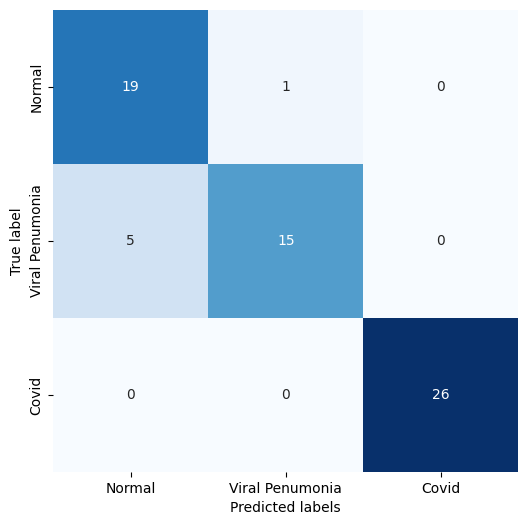

In [ ]:
# Set the size of the figure for the heatmap
plt.figure(figsize=(6, 6))
# Compute the confusion matrix based on true and predicted labels
hm = sns.heatmap(confusion_matrix(ytest, ypred_test_tune), annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False,xticklabels=['Normal','Viral Penumonia','Covid'],yticklabels=['Normal','Viral Penumonia','Covid'])
hm.set(xlabel='Predicted labels') # Set the x-axis label for the heatmap
hm.set(ylabel='True label') # # Set the y-axis label for the heatmap

Here our model was mostly correct in diagnosing the condition based on the X-ray images.

However, we must discuss where it coulnt'. It detected 5 of the Pneumonia cases as Normal and 1 Normal cases as Pneumonia. Rest all images were predicted correctly (shown diagonally).

The incorrect diagnosis can be explained by the fact that:
*   Our model has 91% accuracy (not 100%)
*   Pneomonia scans are half way distinguishable between Normal and Covid
*   Some of the Pneomonia patients may be close to recoving when the scan was taken or it could be the Pneumonia may have just started. In both these cases the scans will look closer to a Normal patient's scan and hence can sometimes confuse the model.

***91% accuracy in diagnosing patients, for the unseen data, is still a very high number compared to diagnosis by Human doctors.***

# Model Deployment

In this section:
*   We will deploy our AI model as a backend on Hugging Face platform.
*   **We will also deploy a front end application that interacts with this backend to take new images from the user and use the backend to get a diagnosis of the image**



## Setting up the python backend

### Setting up Hugging Face Docker space for the backend

Let's setup a repository to host our backend on Hugging face

In [ ]:
# Import the login function from the huggingface_hub library
from huggingface_hub import login

# Login to your Hugging Face account using your access token
login(token="<redacted-token-here>")

# Import the create_repo function from the huggingface_hub library
from huggingface_hub import create_repo

In [ ]:
# Create a repository for the backend application in the Hugging Face Space
try:
    create_repo("covid19-diagnosis",  # name of the repository as "superkartbackend"
        repo_type="space",  # repository type as "space"
        space_sdk="docker",  # SDK as "docker"
        private=False  # Set it as public space
    )
except Exception as e:
    # Handle potential errors during repository creation
    if "RepositoryAlreadyExistsError" in str(e):
        print("Repository already exists. Skipping creation.")
    else:
        print(f"Error creating repository: {e}")

Error creating repository: 409 Client Error: Conflict for url: https://huggingface.co/api/repos/create (Request ID: Root=1-6964431a-20fce7341c7f71426c3285f5;830cb193-b320-4241-b312-0fdabd3e549f)

You already created this space repo: rduseja14/covid19-diagnosis


### Export the backend code

Let's export the code that we want to deploy to our backend

In [ ]:
import os

# Create a folder for storing the files needed for frontend UI deployment
os.makedirs("backend_files", exist_ok=True)

In [ ]:
%%writefile backend_files/app.py

# Import necessary libraries
from flask import Flask, request, jsonify  # For creating the Flask API
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
import os


# Initialize Flask app with a name
covid19_api = Flask("Covid-19 detection from x-ray images")

# Some constants needed by the model
class_names = ['Normal', 'Viral Pneumonia','Covid']
height, width = 224, 224

# Load the trained keras model
loaded_model = keras.models.load_model('./model/tuned_ai_model_best.model.keras')

ALLOWED_EXTENSIONS = set(['jpeg', 'jpg', 'png'])
app = Flask(__name__)
app.config['UPLOAD_FOLDER'] = "./uploaded"
app.config['MAX_CONTENT_LENGTH'] = 500 * 1000 * 1000  # 500 MB
app.config['CORS_HEADER'] = 'application/json'

def allowedFile(filename):
    return '.' in filename and \
           filename.rsplit('.', 1)[1].lower() in ALLOWED_EXTENSIONS

# Define a route for the home page
@covid19_api.get('/')
def home():
    """
    This function handles GET requests to the root URL ('/') of the API.
    It returns a simple welcome message.
    """
    return "Welcome to the Covid-19 detection backend APIs"

# Define an endpoint to detect covid-19 from uploaded image files
@covid19_api.post('/v1/predict')
def upload_file():
    uploaded_file = request.files['file']
    if uploaded_file.filename != '':
        if allowedFile(uploaded_file.filename):
            uploaded_file_path = os.path.join(app.config['UPLOAD_FOLDER'],uploaded_file.filename)
            uploaded_file.save(uploaded_file_path)

            img_arr = preprocess_image(uploaded_file_path, (height, width))
            predictions = loaded_model.predict(img_arr) # predictions contain probabilities of Normal, Viral Pnemonia and Covid

            # take the prediction as the class with max probabilities
            predicted_class_indices = np.argmax(predictions, axis=1)
            predicted_class_name = class_names[predicted_class_indices[0]]
            # confidence is the probability of the predicted class
            confidence = predictions[0][predicted_class_indices[0]]

            if os.path.isfile(uploaded_file_path) or os.path.islink(uploaded_file_path):
                os.unlink(uploaded_file_path)
            return jsonify({'Diagnosis': f'{predicted_class_name}',  'Confidence': f'{confidence}', 'Raw Probabilities': {'Normal':f'{predictions[0][0]}', 'Viral Pneumonia':f'{predictions[0][1]}', 'Covid-19':f'{predictions[0][2]}' }}), 200
        else:
            return jsonify({'message': 'File type not allowed'}), 400
    else:
        return jsonify({'message': 'File not uploaded'}), 400


def preprocess_image(img_path, target_size):
    # Load the image and resize it to the target size
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=target_size)
    # Convert the PIL image object to a numpy array
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    # Expand the dimensions to create a batch size of 1
    # Models expect input in the shape [batch_size, height, width, channels]
    img_array = np.expand_dims(img_array, axis=0)
    # Rescale to match the training process
    img_array /= 255.0
    return img_array

# Run the Flask app in debug mode
if __name__ == '__main__':
    covid19_api.run(debug=True)

Overwriting backend_files/app.py


In [ ]:
%%writefile backend_files/requirements.txt
pandas==2.2.2
numpy==2.0.2
pillow==11.3.0
tensorflow==2.18.1
ml_dtypes==0.5
Werkzeug==2.2.2
flask==2.2.2
gunicorn==20.1.0
requests==2.32.3
uvicorn[standard]

Writing backend_files/requirements.txt


In [ ]:
%%writefile backend_files/Dockerfile
FROM python:3.9-slim

# Set the working directory inside the container
WORKDIR /app

# Copy all files from the current directory to the container's working directory
COPY . .

# Install dependencies from the requirements file without using cache to reduce image size
RUN pip install --no-cache-dir --upgrade -r requirements.txt

RUN mkdir model
RUN mkdir uploaded

COPY tuned_ai_model_best.model.keras ./model


# Define the command to start the application using Gunicorn with 4 worker processes
# - `-w 4`: Uses 4 worker processes for handling requests
# - `-b 0.0.0.0:7860`: Binds the server to port 7860 on all network interfaces
# - `app:app`: Runs the Flask app (assuming `app.py` contains the Flask instance named `app`)
CMD ["gunicorn", "-w", "4", "-b", "0.0.0.0:7860", "app:covid19_api"]

Writing backend_files/Dockerfile


### Uploading backend code to hugging face

Let's deploy our frontend app to hugging face repo.
*   Hugging face reppository for the backend is available here: https://huggingface.co/spaces/rduseja14/covid19-diagnosis
*   The API home is avalable at: https://rduseja14-covid19-diagnosis.hf.space/
*   The predict API is available at: https://rduseja14-covid19-diagnosis.hf.space/v1/predict

In [ ]:
from huggingface_hub import login, HfApi

# for hugging face space authentication to upload files
access_key = "<redacted-token-here>"
repo_id = "rduseja14/covid19-diagnosis"

# Login to Hugging Face platform with the access token
login(token=access_key)

# Initialize the API
api = HfApi()

# Upload Streamlit app files stored in the folder called deployment_files
api.upload_folder(
    folder_path="backend_files",
    repo_id=repo_id,  # Hugging face space id
    repo_type="space",  # Hugging face repo type "space"
)

## Deploying the front end

### Setting up Hugging Face Docker space for the front end

Let's setup a repository to host our frontend on Hugging face

In [ ]:
# Import the login function from the huggingface_hub library
from huggingface_hub import login

# Login to your Hugging Face account using your access token
login(token="<redacted-token-here>")

# Import the create_repo function from the huggingface_hub library
from huggingface_hub import create_repo

In [ ]:
# Create a repository for the front end application in the Hugging Face Space
try:
    create_repo("covid19-diagnosis-frontend",
        repo_type="space",  # repository type as "space"
        space_sdk="docker",  # SDK as "docker"
        private=False  # Set it as public space
    )
except Exception as e:
    # Handle potential errors during repository creation
    if "RepositoryAlreadyExistsError" in str(e):
        print("Repository already exists. Skipping creation.")
    else:
        print(f"Error creating repository: {e}")

### Export the front end code

Let's export the code that we want to deploy to our frontend

In [ ]:
import os

# Create a folder for storing the files needed for frontend UI deployment
os.makedirs("frontend_files", exist_ok=True)

In [ ]:
%%writefile frontend_files/app.py

import streamlit as st
import requests
from PIL import Image

# Configuration
API_URL = "https://rduseja14-covid19-diagnosis.hf.space/v1/predict"

st.set_page_config(
    page_title="Covid-19 detection from x-ray images",
    layout="centered"
)

def main():
    st.title("🩻 Detecting Covid-19 from Chest X-Ray radiology images")
    st.markdown("""
    Upload a chest X-ray image (JPEG/JPG) to detect the presence of COVID-19.
    The image will be analyzed by our AI model.
    """)

    # File uploader
    uploaded_file = st.file_uploader("Choose a Chest X-Ray Image", type=["jpg", "jpeg", "png"])

    if uploaded_file is not None:
        # Display the uploaded image
        try:
            image = Image.open(uploaded_file)
            st.image(image, caption='Uploaded X-Ray')

            # Predict button
            if st.button('🔍 Analyze Image', type="primary"):
                with st.spinner('Analyzing image for COVID-19...'):
                    make_prediction(uploaded_file)

        except Exception as e:
            st.error(f"Error loading image: {e}")

def make_prediction(file_obj):
    # Reset file pointer to beginning
    file_obj.seek(0)

    try:
        # Prepare the file for the POST request
        # The key must be 'file' as requested
        files = {'file': (file_obj.name, file_obj, file_obj.type)}

        response = requests.post(API_URL, files=files, verify=False)

        if response.status_code == 200:
            result = response.json()

            # Display results
            st.success("Analysis Complete!")

            # Use an expander to show raw JSON if needed, or just show main result
            # Assuming the result has some readable keys, we'll display the raw json for now
            # and can refine if we know the exact schema.
            st.write("### Prediction Results:")
            st.json(result)

        else:
            st.error(f"Error from API (Status Code: {response.status_code})")
            st.text(response.text)

    except requests.exceptions.RequestException as e:
        st.error(f"Connection Error: {e}")
    except Exception as e:
        st.error(f"An unexpected error occurred: {e}")

if __name__ == "__main__":
    main()


Writing frontend_files/app.py


In [ ]:
%%writefile frontend_files/README.md
---
title: Covid-19 detection from Radiology images
emoji: "🚀"
colorFrom: "blue"
colorTo: "green"
sdk: streamlit
sdk_version: "1.46.0"
app_file: app.py
pinned: false
---

Overwriting frontend_files/README.md


In [ ]:
%%writefile frontend_files/requirements.txt
streamlit
requests
Pillow

Writing frontend_files/requirements.txt


In [ ]:
%%writefile frontend_files/Dockerfile
# Use a minimal base image with Python 3.9 installed
FROM python:3.9-slim

# Set the working directory inside the container to /app
WORKDIR /app

# Copy all files from the current directory on the host to the container's /app directory
COPY . .

# Install Python dependencies listed in requirements.txt
RUN pip3 install -r requirements.txt

# Define the command to run the Streamlit app on port 8501 and make it accessible externally
CMD ["streamlit", "run", "app.py", "--server.port=8501", "--server.address=0.0.0.0", "--server.enableXsrfProtection=false"]

# NOTE: Disable XSRF protection for easier external access in order to make batch predictions

Writing frontend_files/Dockerfile


### Uploading frontend code to hugging face

And finally, let's deploy our frontend app to hugging face repo

*   Hugging face reppository for the frontend is available here: https://huggingface.co/spaces/rduseja14/covid19-diagnosis-frontend
*   The front end is accessible from here: https://rduseja14-covid19-diagnosis-frontend.hf.space/

In [ ]:
from huggingface_hub import login, HfApi

access_key = "<redacted-token-here>"  #Complete the code to define the access token
repo_id = "rduseja14/covid19-diagnosis-frontend"  #Complete the code to define the repo id

# Login to Hugging Face platform with the access token
login(token=access_key)

# Initialize the API
api = HfApi()

# Upload Streamlit app files stored in the folder called deployment_files
api.upload_folder(
    folder_path="frontend_files",
    repo_id=repo_id,  # Hugging face space id
    repo_type="space",  # Hugging face repo type "space"
)

CommitInfo(commit_url='https://huggingface.co/spaces/rduseja14/covid19-diagnosis-frontend/commit/9c7eda18088f6825c35139e1ac84bdfe714f6073', commit_message='Upload folder using huggingface_hub', commit_description='', oid='9c7eda18088f6825c35139e1ac84bdfe714f6073', pr_url=None, repo_url=RepoUrl('https://huggingface.co/spaces/rduseja14/covid19-diagnosis-frontend', endpoint='https://huggingface.co', repo_type='space', repo_id='rduseja14/covid19-diagnosis-frontend'), pr_revision=None, pr_num=None)

##